# Comparing maternal mortality rate with female life expectancy in 2020

In [1]:
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from plotnine import *

In [2]:
# Find the paths to installed fonts
font_path = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# Add custom fonts (if they exist on the user's computer)
lato_paths = [font for font in font_path if 'Lato' in font]
for path in lato_paths: 
    fm.fontManager.addfont(path)

playfair_paths = [font for font in font_path if 'Playfair' in font]
for path in playfair_paths:
    fm.fontManager.addfont(path)

In [16]:
# UN Population Prospects
pop = pd.read_excel('data/UN-world-population-data.xlsx', header=16)

# WHO Maternal Mortality Rates
mmr = pd.read_csv('data/WHO-maternal-mortality-rates.csv', index_col=False)

# Continent definitions from Our World in Data
cont = pd.read_csv('data/continent-definitions.csv')

# Clean continent definitions
cont = (
    cont
    .rename(columns={'Entity': 'Country'})
    .drop(columns=['Code', 'Year'])
)

In [4]:
# Filter for maternal mortality rate in 2020
mmr_2020 = (
    mmr
    .loc[mmr['DIM_TIME'] == 2020, ['GEO_NAME_SHORT', 'VALUE_NUMERIC']]
    .rename(columns={'GEO_NAME_SHORT': 'Country', 'VALUE_NUMERIC': 'Maternal Mortality Rate'})
)

# Filter for female life expectancy in 2020
fle_2020 = (
    pop
    .loc[(pop['Type'] == 'Country/Area') & (pop['Year'] == 2020), ['Region, subregion, country or area *', 'Female Population, as of 1 July (thousands)', 'Female Life Expectancy at Birth (years)']]
    .rename(columns={'Region, subregion, country or area *': 'Country'})
)

data = mmr_2020.merge(fle_2020, on='Country').dropna().merge(cont, on='Country')

In [14]:
data['Female Life Expectancy at Birth (years)'] = data['Female Life Expectancy at Birth (years)'].astype(float)
data['Female Population, as of 1 July (thousands)'] = data['Female Population, as of 1 July (thousands)'].astype(float)
data['Female Population (Million)'] = data['Female Population, as of 1 July (thousands)'] / 1000

# Choose select countries to label on the graph
data = data.set_index('Country')
countries_to_label = ['Nigeria', 'Haiti', 'Papua New Guinea', 'Ecuador','Germany', 'Japan']
data['Show Label'] = False
data.loc[countries_to_label, 'Show Label'] = True
data = data.reset_index()

# Set alpha based on 'Show Label' column
data['Alpha'] = 0.2
data.loc[1, 'Alpha'] = 0
data.loc[data['Show Label'], 'Alpha'] = 1.0

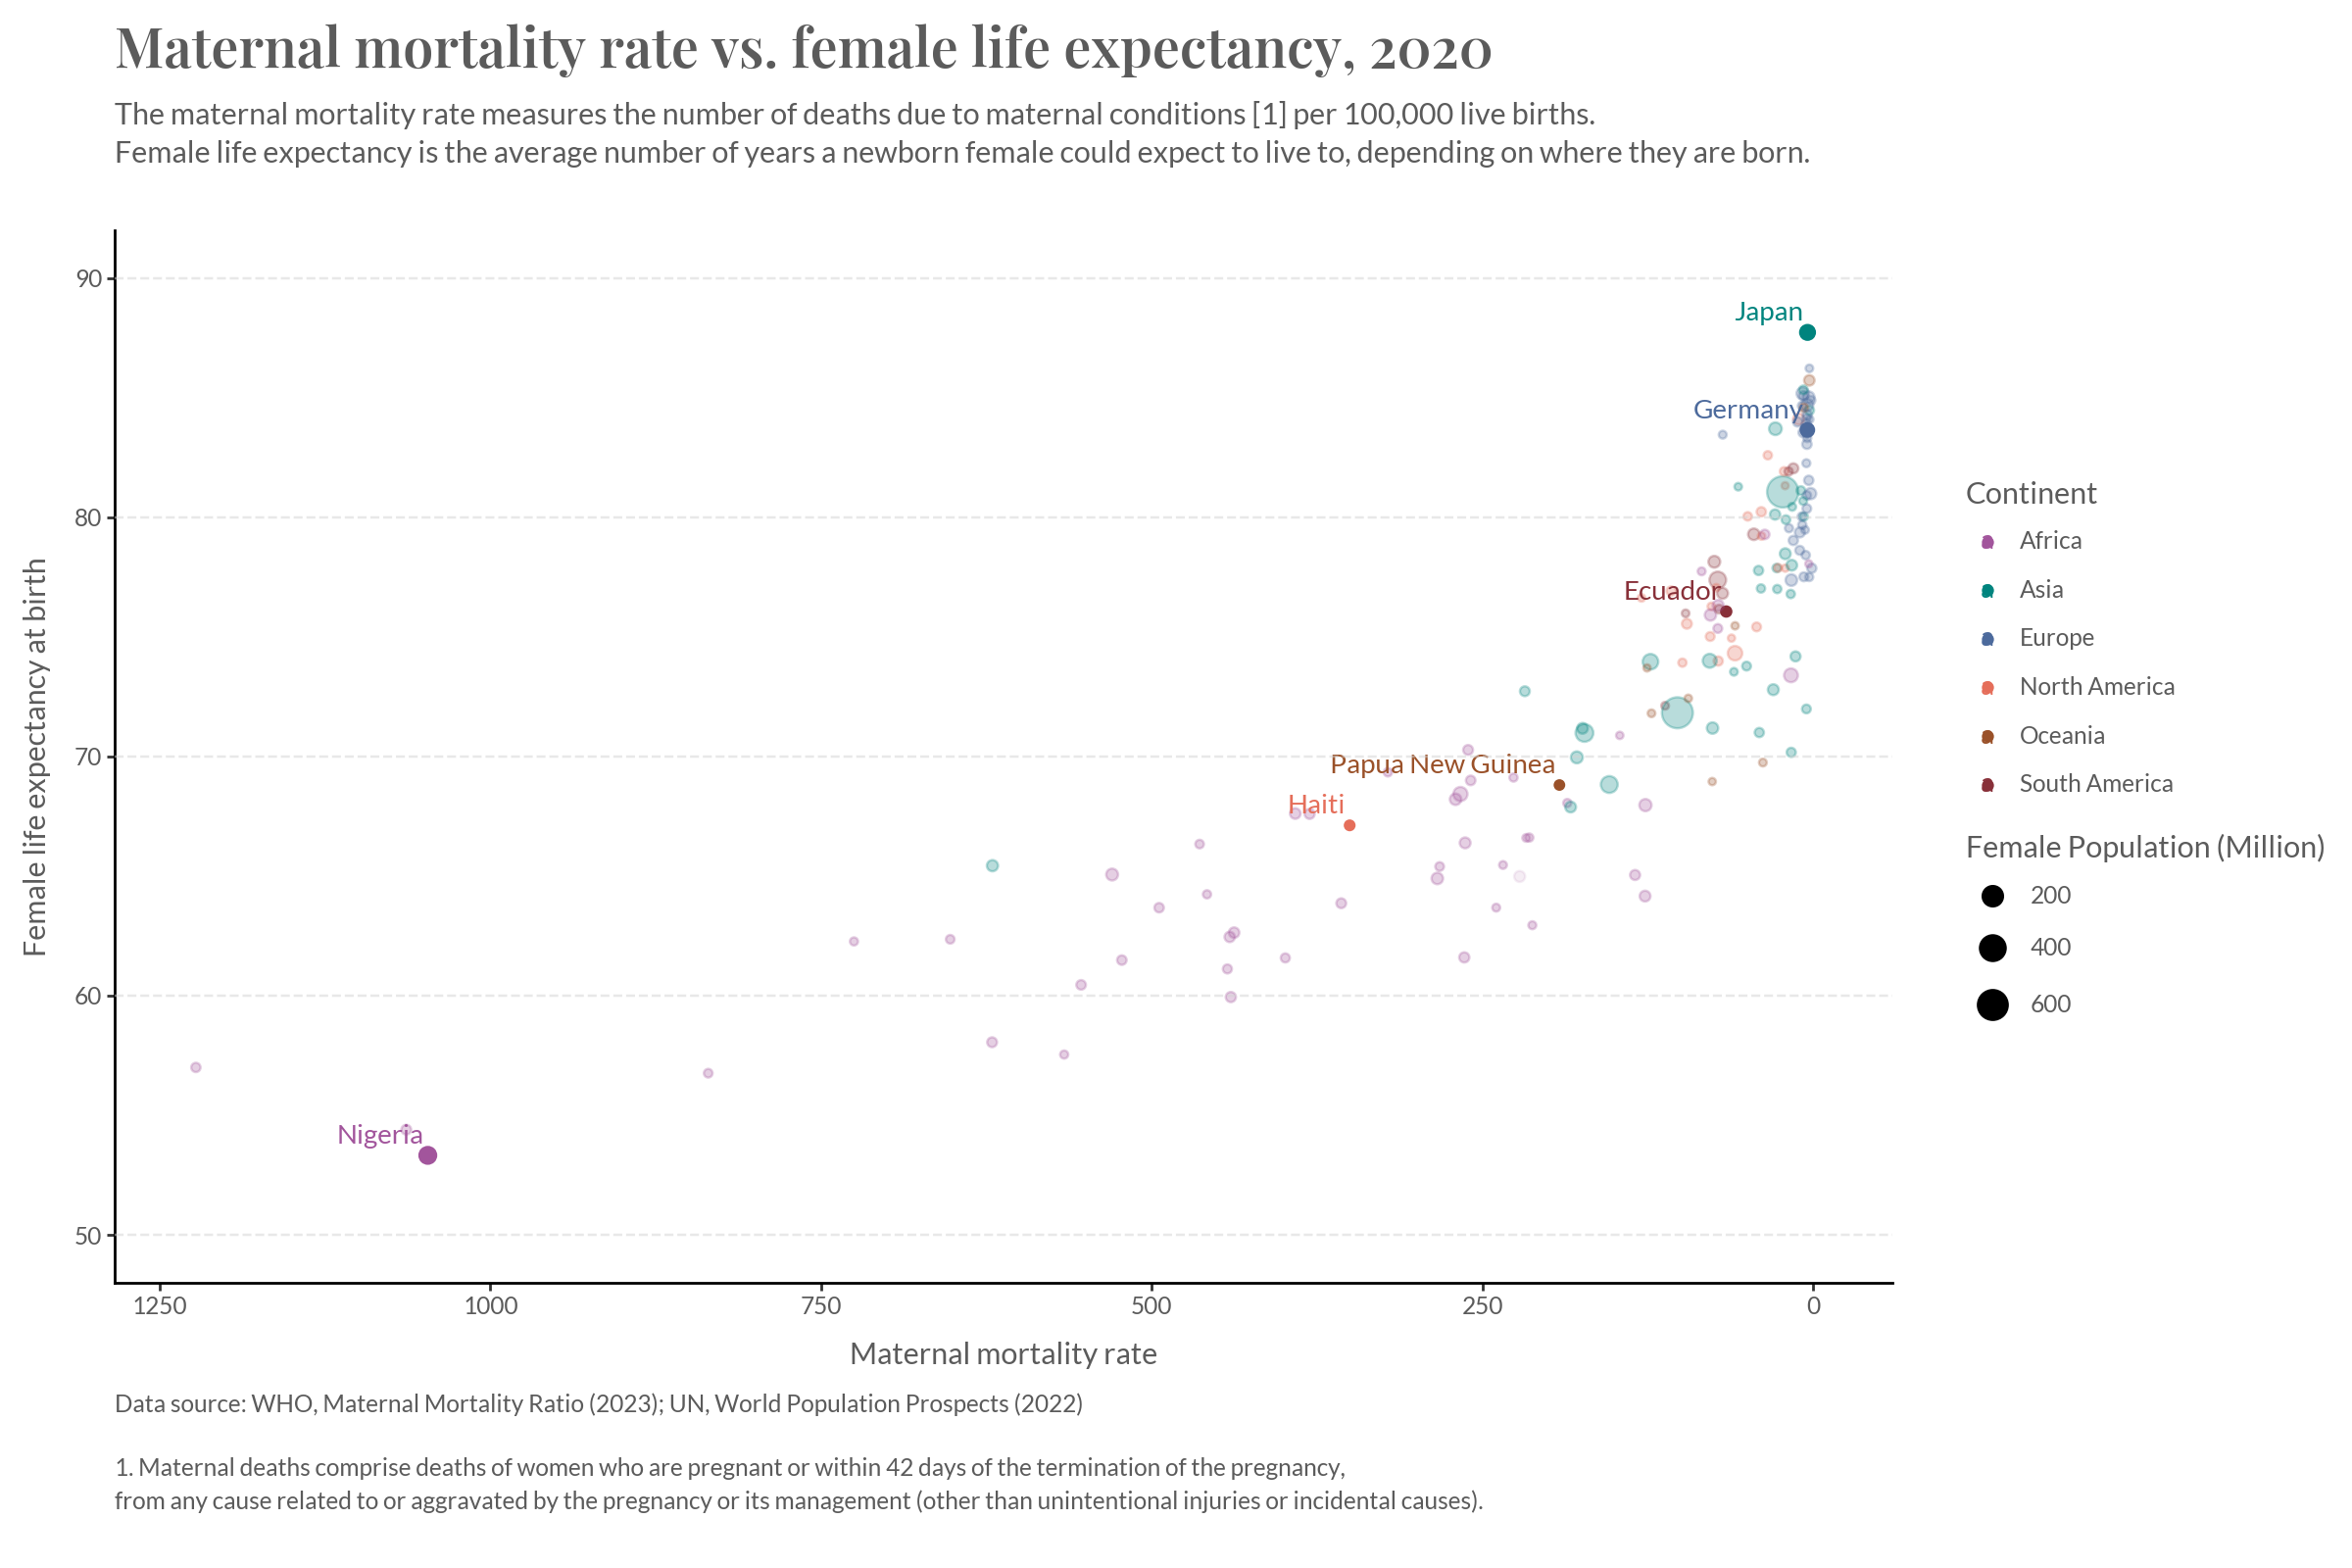

In [15]:
# Define the metadata
title = "Maternal mortality rate vs. female life expectancy, 2020"
subtitle = """\
The maternal mortality rate measures the number of deaths due to maternal conditions [1] per 100,000 live births.
Female life expectancy is the average number of years a newborn female could expect to live to, depending on where they are born.
"""
caption = """\
Data source: WHO, Maternal Mortality Ratio (2023); UN, World Population Prospects (2022)

1. Maternal deaths comprise deaths of women who are pregnant or within 42 days of the termination of the pregnancy, 
from any cause related to or aggravated by the pregnancy or its management (other than unintentional injuries or incidental causes).
"""

# Set fonts for the plot
default_font = 'Dejavu Sans'
title_font = 'Playfair Display' if playfair_paths else default_font
text_font = 'Lato' if lato_paths else default_font

# Define colors for each continent
continent_colors = {
    'Africa': '#A2559C',
    'Asia': '#00847E',
    'Europe': '#4C6A9C',
    'North America': '#E56E5A',
    'Oceania': '#9A5129',
    'South America': '#883039'
}

# Set classic theme for clean output
theme_set(theme_classic());

(
    ggplot(
        data, 
        aes(
            'Maternal Mortality Rate', 
            'Female Life Expectancy at Birth (years)', 
            label='Country', 
            color='Continent', 
            size='Female Population (Million)', 
            alpha='Alpha'
        )
    )
    + geom_point()
    # Display labels for selected countries
    + geom_text(
        data=data[data['Show Label']], 
        size=10, 
        nudge_y=0.8, 
        nudge_x=-3, 
        ha="right"
    )
    + labs(
        x="Maternal mortality rate",
        y="Female life expectancy at birth",
        title=title,
        subtitle=subtitle,
        caption=caption,
    )
    # Differentiate countries by continent, marked by different colours
    + scale_color_manual(values=continent_colors)
    + guides(alpha=False)
    + ylim(50, 90)
    + scale_x_reverse()
    + geom_hline(
        yintercept=np.linspace(50, 90, 5), 
        linetype='dashed', 
        color='lightgrey', 
        alpha=0.5
    )
    # Adjust text elements, and incorporate custom fonts
    + theme(
        plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}),
        plot_title=element_text(family=title_font, size=20, weight='semibold'),
        text=element_text(family=text_font, linespacing=1.5, color='#5B5B5B'),
        figure_size=(12, 8),
    )
)